## Objectives
<br></br>
Order systems that quote users a final up-front rate and await payment before executing on the liquidity-sourcing venue, are naturally exposed to price fluctuations that can impact the profitability of each trade.

Depending on the payment method, the time between initial quote presentation and payment completion will vary e.g card payments take less time to complete (initiate + settle) than real-time bank-transfer based payments.

The objective of this analysis is to investigate and quanitfy the local changes in price for cryptocurrencies, whose volatility  may present a problem in the context of profitable pricing.

This analysis could help inform brokerages and other parties that operate order execution systems that operate using the abovementioned setup.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from __future__ import division
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
paths_input = os.path.abspath(os.path.join('..','input'))
paths_data = os.path.abspath(os.path.join('..','data'))

## 1. Import Data


Data: GBP/BTC historical trade data

Source: Coinsbank Exchange from https://api.bitcoincharts.com/v1/csv/.

In [3]:
trade_data_df = pd.read_csv(paths_input+"/coinsbankGBP.csv.gz", 
                compression = 'gzip',
                names = ['timestamp','price','amount'],
                dtype = {'timestamp':float, 'price':float, 'amount':float},
                index_col = ['timestamp'])

C:\Users\Yousa\Anaconda2\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 2. Clean Data


### 2.1 Inspect Data

Let's see what an initial look at the data can tell us.

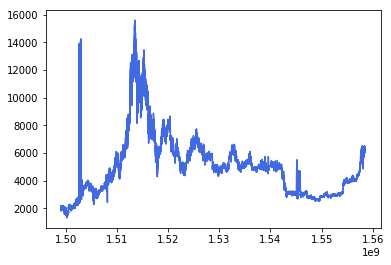

In [4]:
fig, ax = plt.subplots()
plt.plot(trade_data_df.index, trade_data_df['price'], c='royalblue', label='original data')
plt.show()

We can see a number of trades were executed at prices far out from the market. 

These data points are considered outliers, as we're interested in the *'mid-market'"* prices for our analysis.

Note, ideally we should use `bid`/`ask` data when analyzing local price movement as it best represents the theoretical prices one would be able to execute (mid-market). 

As this data was not available, historical trade data (`last` values) will be used instead. Exepectedly, this will contain trades executed at prices far out from the market which is what we've noticed from the graph.

### 2.2 Identify Outliers

First, we'll create an array, **x**, to store our data in 4 columns:

- timestamp
- price, original data
- price, identified anomolies
- price, anomoly-free

In [5]:
x = np.array((trade_data_df.index,trade_data_df['price'])).transpose()
x = np.concatenate((x,np.zeros((trade_data_df.shape[0],2))), axis=1)

Next, we'll build a function to help us identify outliers.

Our function works as follows:

1. Split the data into windows, each containing a `win_size` number of trades
2. Calculate the z score of each price in a given window
3. If a price lies 3σ away from the mean, mark it is an outlier

In [6]:
def mark_anomalies(x,win_size):
    for i in range(0,int(x.shape[0]/win_size)):
        z = np.abs(stats.zscore(x[(i*win_size):(i+1)*win_size,1]))

        for j in range (0,win_size):
            price = x[(i*win_size)+j,1]
            if z[j] > 3:
                #print "anomaly"
                x[(i*win_size)+j,2] = price
                x[(i*win_size)+j,3] = np.nan
            else:
                x[(i*win_size)+j,2] = np.nan
                x[(i*win_size)+j,3] = price
                
    #discard remainder values that don't fit into  window                
    x = x[:-(x.shape[0]%win_size)]
    return x

Let's call the function to mark our anomolies. 

We'll use a `win_size` of 5000 - about 0.4% of the total trades.

In [7]:
x = mark_anomalies(x,5000)

Visualizing the marked anomolies 

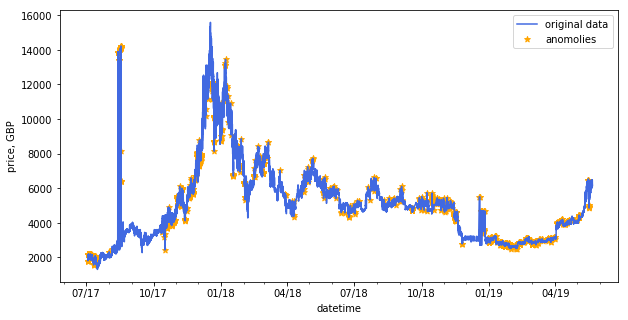

In [8]:
datetimes = np.array(x[:,0], dtype = 'datetime64[s]')
p_original = x[:,1]
p_anom = x[:,2]
p_clean = x[:,3]


fig, ax = plt.subplots(figsize=(10,5))
plt.plot(datetimes, p_original, c='royalblue', label='original data')
plt.scatter(datetimes, p_anom, c='orange', label='anomolies', marker = '*')
plt.xlabel('datetime')
plt.ylabel('price, GBP')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.show() 

Now without the anamolies..

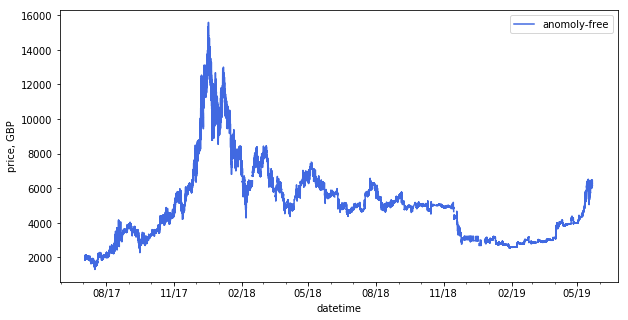

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(datetimes, p_clean, c='royalblue', label='anomoly-free')
plt.xlabel('datetime')
plt.ylabel('price, GBP')
plt.legend()  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.show() 

The results suggest our used `win_size` value of 5000 was well measured; a significant number of outliers have been removed without over-fitting the data. 

### 2.3 Clean data format

As we're interested in price movements at the minute scale, we'll truncate the `datetime` values to represent minute precision.

This means, for example, a trade completed after `12:59:00` but before `13:00:00` will be indexed against `12:59:00`.   

In [10]:
x[:,0] = x[:,0] - (x[:,0]%60)

Next we'll move the data into a dataframe and remove the anomolies found, ready for running our analysis.

In [11]:
datetimes = np.array(x[:,0], dtype = 'datetime64[s]')

clean_data_df = pd.DataFrame(data = p_clean, index = datetimes)
clean_data_df.index.name = 'datetime'

#remove anomolous prices as marked (NaNs) earlier
clean_data_df = clean_data_df.dropna(axis = 0, how = 'any')

In [12]:
clean_data_df.iloc[:5]

,0
datetime,
2017-07-03 06:05:00,1892.000
2017-07-03 06:07:00,1888.899
2017-07-03 06:07:00,1892.000
2017-07-03 06:09:00,1892.000
2017-07-03 06:11:00,1892.000


### 2.4 Extract relvant subset of data

The data set spans a large time period.

As our analysis is intended to help us understand price behaviour in the near future, it makes more sense to analyze a subset of the data for a time period which best resembles current market conditions.

<figure>
  <img src="../input/market_variables.PNG" alt="Drawing" style="width: 800px;"/>
  <figcaption>Source: https://www.buybitcoinworldwide.com/volatility-index/</figcaption>
</figure>

The time period, July 2017 - Dec 2017, in the shaded region is most suitable since:

- current **volatility** levels are close to those around July 2017
- current **price** levels are close to that those around July 2017
- the general price trend was positive, matching current general sentimenets
- a reasonable range of volatility was experienced 3-7%

In [13]:
clean_data_df = clean_data_df.loc['2017-07-14':'2017-12-14']

clean_data_df.shape

(219092, 1)

## 3. Analyze Data

### 3.1 Method

We want to investigate the change in price, `delta_p` over a time period, `delta_t`.

`t1` is the time of the first trade, `p1` is the price for that trade.
`t2` is the time of the second trade, where `t2` = `t1` + `delta_t`). `p2` is the price for the trade at time `t2`.

This function will find all data points that are situated `delta_t` minutes apart from each other and calculate the increase in price,`delta_p`.

In [14]:
def calculate_delta_p(delta_t,j):
    t1 = clean_data_df.index[j]
    
    try:    
        p1 = clean_data_df.loc[t1][0][0]#if multiple trades are found at that minute, take the first
    except IndexError:
        p1 = clean_data_df.loc[t1][0]
        
    t2 = clean_data_df.index[j] + datetime.timedelta(minutes=delta_t)
    
    try:
        p2 = clean_data_df.loc[t2][0][0]#if multiple trades are found at that minute, take the first
        delta_p = (p2/p1)-1
        
    except IndexError:
        p2 = clean_data_df.loc[t2][0]
        delta_p = (p2/p1)-1
        
    except KeyError:    
        delta_p = np.nan #meaning there wasn't a trade at t2
               
    return delta_p

We're going to use `delta_t` values of [1,2,3,4,5,6,7] as it is reasonable most real-time payment methods would not take longer to complete.

We'll create an empty numpy array to store all the `delta_p` values, with 7 columns, each corresponding to an incrementing `delta_t` value.

In [15]:
delta_ps = np.zeros((clean_data_df.shape[0],7))

Let's populate the array by calling the `calulate_delta_p` function in a nested for loop.

**The runtime of the function was ~32mins** on an array with 219092 rows (trades) and 7 columns (`delta_ts`) .

In [16]:
#for y in range(0,delta_ps.shape[1]):
#    for i in range(0,clean_data_df.shape[0]):
#        delta_ps[i,y] = calculate_delta_p(y+1,i)

If you don't wish to run the function you can load the resulting array from the supporting files.

In [17]:
delta_ps = np.load(paths_data+"/delta_ps_Jul17_Dec17.npy")
delta_ps[1020,:]

array([-0.01581017,  0.00313283,  0.05392006,  0.03880524,  0.02654791,
        0.02654791,  0.05541674])

### 3.2 Results

Let's visualize the distribution of the local price changes using histograms.

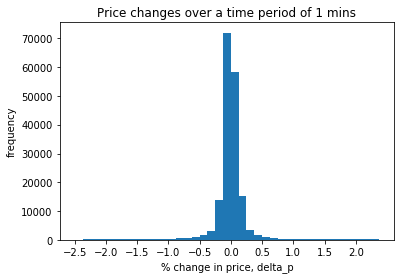

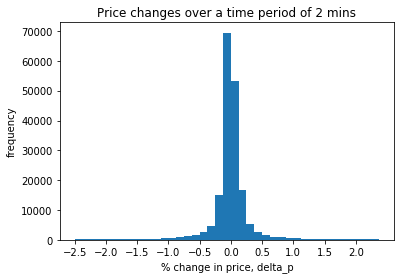

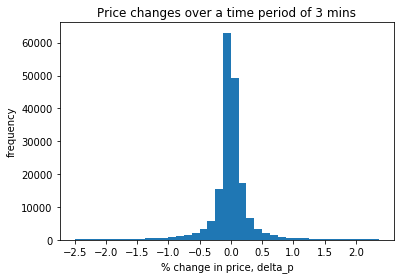

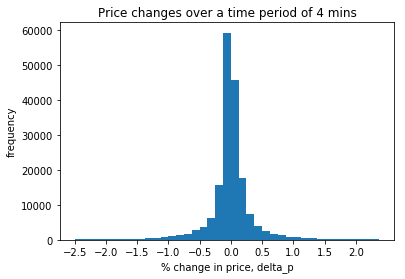

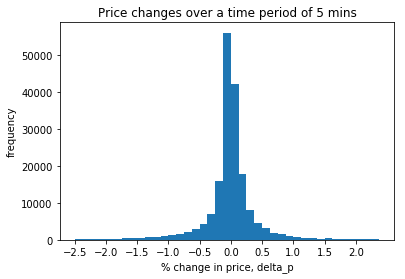

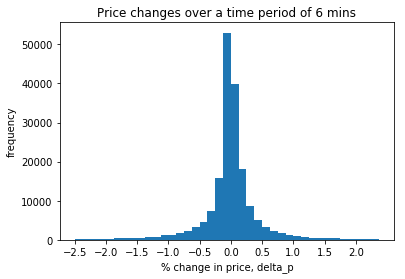

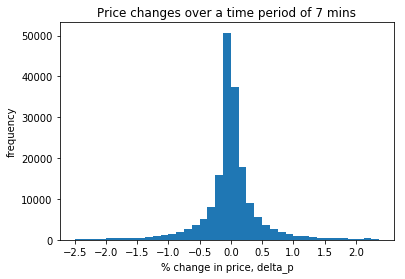

In [18]:
for i in range(0,delta_ps.shape[1]):
    plt.figure()
    plt.title('Price changes over a time period of '+str(i+1)+' mins')
    plt.xlabel('% change in price, delta_p')
    plt.ylabel('frequency')
    plt.xticks((np.arange(-0.025,0.025,0.005).transpose()*100))
    plt.hist((delta_ps[:,i][~np.isnan(delta_ps[:,i])]*100),
             bins=(np.arange(-0.025,0.025,0.00125).transpose())*100,
             range=(0.02,0.02))

A couple observations can be made:

1. Most notably, the majority of `delta_p` values fall between -0.25% and 0.00% across all `delta_t` values
2. Not withstanding the -0.50 - 0.00 range, there appears to be a bias towards prices increasing (negative skew)

Let's calculate the mean price change, `delta_p`, for the various time periods to verify observation 2. 

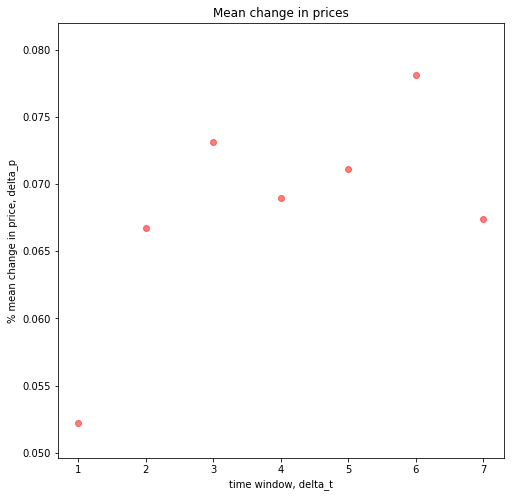

In [19]:
delta_ts = range(1,8)
pds_avg = [np.nanmean(delta_ps[:,i-1])*100 for i in delta_ts]

plt.figure(figsize=(8,8))
plt.scatter(delta_ts, pds_avg, alpha=0.5, marker='o', c='r')
plt.title('Mean change in prices')
plt.xlabel('time window, delta_t')
plt.ylabel('% mean change in price, delta_p')
plt.ylim(0.95*min(pds_avg),1.05*max(pds_avg))
plt.show()

This confirms observation 2: on average the price change tends to be positve. 

There is a positive correlation between `delta_t` and the mean `delta_p`.

Let's look at how the variance of the price changes changes with `delta_t`

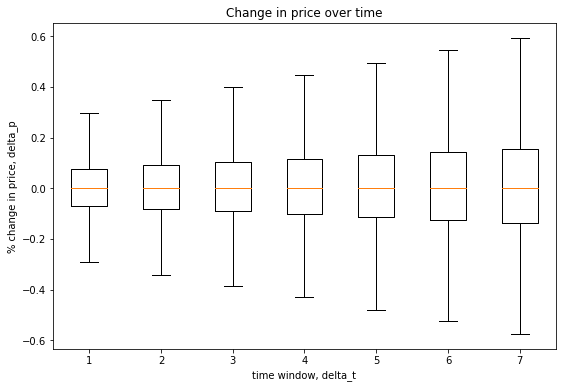

In [20]:
pds_ = [delta_ps[:,i-1][~np.isnan(delta_ps[:,i-1])]*100 for i in delta_ts]

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(pds_,showfliers=False)
plt.title('Change in price over time')
plt.xlabel('time window, delta_t')
plt.ylabel('% change in price, delta_p')
plt.show()

We learn the following

- As `delta_t` increases, the variance of `delta_p` values increase.
- Across all time windows, 50% of the changes in price fell between -0.10% and 0.10%.
- A slight assymetry to price changes arises for `delta_t` values greater than 3..

## 4 Findings

Order systems that quote users a final up-front rate and await payment before executing on the liquidity-sourcing venue, are naturally exposed to price fluctuations that can impact the PnL of each trade.

Depending on the payment method, the time window, `delta_t`, between initial quote presentation and payment completion will vary e.g card payments take less time to complete (initiate + settle) than real-time bank-transfer based payments.

The objective of this analysis was to investigate and quanitfy the impact on trade PnLs by local price movements for a range of time windows, `delta_t`. 



**Impact on trade PnL can be considered to be miminimal:**

- Since the distribution of price change is almost symmetric i.e there will be an almost equal amount of instances where prices move in a favorable direction as an unfavorable direction. 
<br></br>
- Whilst this observation holds true at the population level (~190,00 trades), it will not hold true for a smaller sample of data points. If a smaller number of trades are expected to be executed, observations at the sample level should be compared to the population level and expectated PnL impact adjusted accordingly.
<br></br>
- This is limited to the time windows considered herein and the relationship is expected to not hold true as `delta_t` increases
<br></br>


**The assymetry of price changes increases as the time window increases**

-  Therefore for payment methods that take longer to *complete*, the applied markup can be increased by an amount equivalent to the mean `delta_p` value in order to offset the expected loss.  
<br></br>
- The impact on PnL for at lower `delta_t` values is immaterial, therefore for payment methods such as card there is no adjsutment necessary to pricing.